In [3]:
pip install transformers accelerate -U hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.8/477.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 74.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from hazm import Normalizer, word_tokenize


## Load Data

In [2]:
from google.colab import drive

drive.mount('/content/drive')
data= pd.read_csv('/content/drive/MyDrive/IRproject/data.csv')

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

Mounted at /content/drive


## Tokenize

In [3]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased-clf-persiannews')
normalizer = Normalizer()

def tokenize_texts(tokenizer, texts):
    normalized_texts = [normalizer.normalize(text) for text in texts]
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
    return encodings

# Tokenize the texts
train_encodings = tokenize_texts(tokenizer, train_texts.tolist())
val_encodings = tokenize_texts(tokenizer, val_texts.tolist())


## PyTorch datasets

In [4]:
# Create PyTorch datasets
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [5]:
train_dataset = MyDataset(train_encodings, train_labels.tolist())
val_dataset = MyDataset(val_encodings, val_labels.tolist())

## training arguments

In [6]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('HooshvareLab/bert-fa-base-uncased-clf-persiannews', num_labels=7, ignore_mismatched_sizes=True)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/IRproject/results2',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/IRproject/logs2',
    logging_steps=100,
    evaluation_strategy='epoch',
    eval_steps=200,
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased-clf-persiannews and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([8, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([8]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set trainer

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train

In [8]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.530800,0.506227,0.850879,0.850254
2,0.313400,0.572905,0.858912,0.858546


TrainOutput(global_step=5974, training_loss=0.5082625480731036, metrics={'train_runtime': 1437.7491, 'train_samples_per_second': 33.241, 'train_steps_per_second': 4.155, 'total_flos': 3143792017305600.0, 'train_loss': 0.5082625480731036, 'epoch': 2.0})

In [ ]:
# trainer.evaluate()

## Evaluation Metrics

In [9]:
val_predictions = trainer.predict(val_dataset)
val_predicted_labels = np.argmax(val_predictions.predictions, axis=1)
val_true_labels = val_dataset[:]["labels"].numpy()

val_accuracy = accuracy_score(val_true_labels, val_predicted_labels)
val_f1 = f1_score(val_true_labels, val_predicted_labels, average="weighted")
val_cm = confusion_matrix(val_true_labels, val_predicted_labels)

print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation F1 Score: {val_f1}")
# print("Validation Confusion Matrix:")
# print(val_cm)

Validation Accuracy: 0.8508786610878661
Validation F1 Score: 0.8502538230378222


## Confusion Matrix

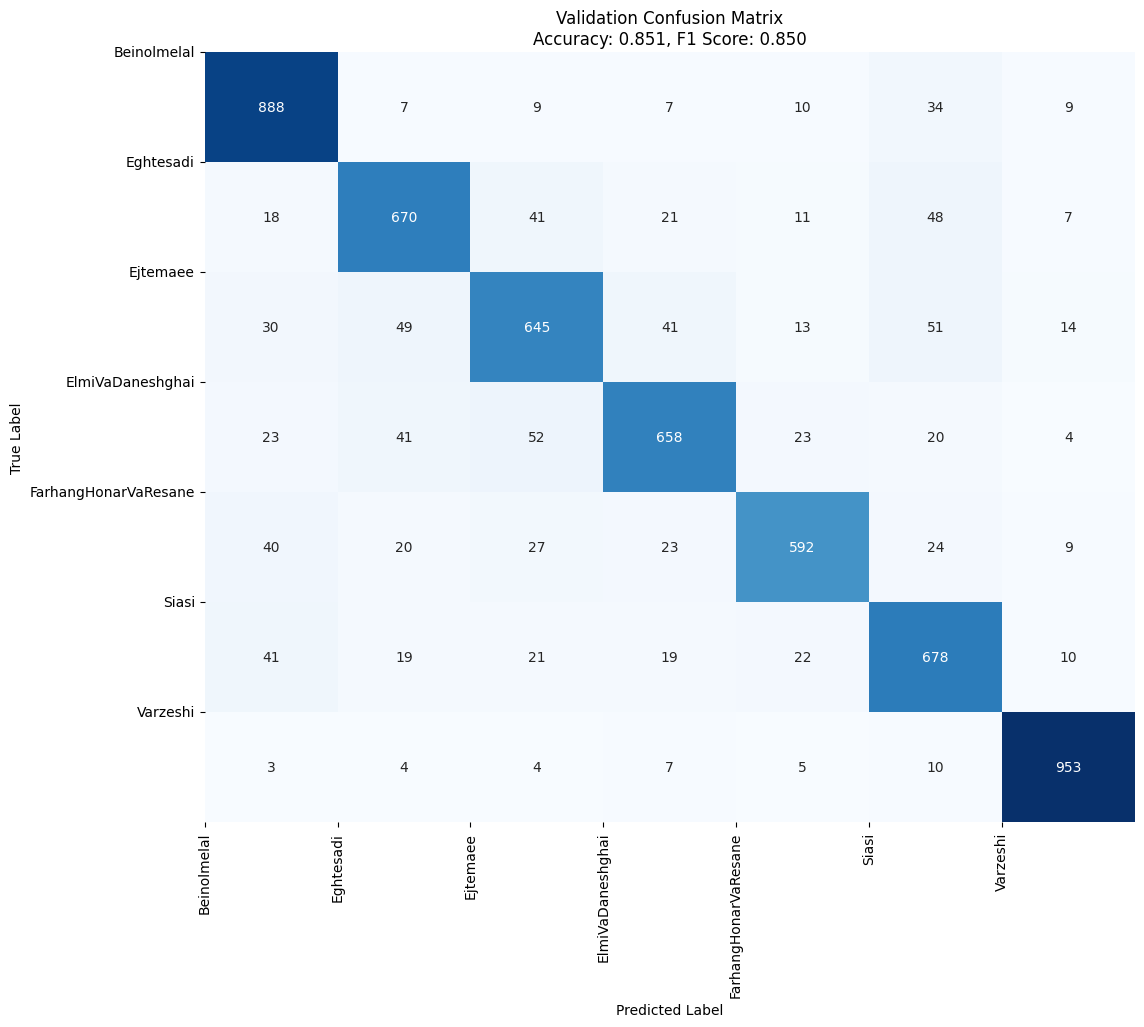

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Customize the plot
class_names = ['Beinolmelal', 'Eghtesadi', 'Ejtemaee', 'ElmiVaDaneshghai', 'FarhangHonarVaResane', 'Siasi', 'Varzeshi']

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Validation Confusion Matrix\nAccuracy: {val_accuracy:.3f}, F1 Score: {val_f1:.3f}")

# Show the plot
plt.show()


# Save Trained Model

In [13]:
output_dir = "/content/drive/MyDrive/IRproject/saved_model2"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/IRproject/saved_model2/tokenizer_config.json',
 '/content/drive/MyDrive/IRproject/saved_model2/special_tokens_map.json',
 '/content/drive/MyDrive/IRproject/saved_model2/vocab.txt',
 '/content/drive/MyDrive/IRproject/saved_model2/added_tokens.json',
 '/content/drive/MyDrive/IRproject/saved_model2/tokenizer.json')

# Test

In [ ]:
# model_path = "/content/drive/MyDrive/IRproject/saved_model"
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
# data= pd.read_csv('/content/drive/MyDrive/IRproject/data.csv')
# test_texts = data["text"]
# test_labels = data["label"]

# # Tokenize the new texts
# test_encodings = tokenize_texts(tokenizer, test_texts.tolist())

# # Create the PyTorch dataset
# test_dataset = MyDataset(test_encodings, test_labels.tolist())

# # Create a new trainer for evaluation
# eval_trainer = Trainer(
#     model=model,
#     args=training_args,
#     eval_dataset=test_dataset,
#     compute_metrics=compute_metrics
# )

# # Evaluate the model
# eval_results = eval_trainer.evaluate()

# cm = confusion_matrix(eval_results.label_ids, eval_results.predictions.argmax(-1))

# # Access the evaluation metrics
# test_accuracy = eval_results["eval_accuracy"]
# test_f1 = eval_results["eval_f1"]

# print(f"Test Accuracy: {test_accuracy}")
# print(f"Test F1 Score: {test_f1}")


In [ ]:
# Create the confusion matrix
# Make predictions on the test dataset
# predictions = eval_trainer.predict(test_dataset)
# predicted_labels = np.argmax(predictions.predictions, axis=1)
# true_labels = test_dataset[:]["labels"].numpy()

# # Calculate the confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns


# # Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# # Customize the plot
# class_names = ['Beinolmelal', 'Eghtesadi', 'Ejtemaee', 'ElmiVaDaneshghai', 'FarhangHonarVaResane', 'Siasi', 'Varzeshi']  # Replace with your class labels

# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names, rotation=90)
# plt.yticks(tick_marks, class_names, rotation=0)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Test data Confusion Matrix")

# # Show the plot
# plt.show()